In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

Namespace(epochs=20, b_size=4, lrd=5e-05, lrg=5e-05, manualSeed=999, traintotal=300, testtotal=40, weight_super=0.99, weight_masscon=10, gpath=None, dpath=None, dup=1, gup=1, noise_mode='real', ngpu=1)
Random Seed:  999
Total amount of files: 13798
Conv3d(1, 2, kernel_size=(3, 4, 4), stride=(1, 2, 2), padding=(1, 1, 1), bias=False)
BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
LeakyReLU(negative_slope=0.2, inplace=True)
Conv3d(2, 4, kernel_size=(3, 4, 4), stride=(1, 2, 2), padding=(1, 1, 1), bias=False)
BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
LeakyReLU(negative_slope=0.2, inplace=True)
Conv3d(4, 8, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
LeakyReLU(negative_slope=0.2, inplace=True)
Conv3d(8, 16, kernel_size=(3, 4, 4), stride=(1, 2, 2), padding=(1, 1, 1), bias=False)
BatchNorm3d(16, eps=1e-05, momentum=0.1, 

BdbQuit: 

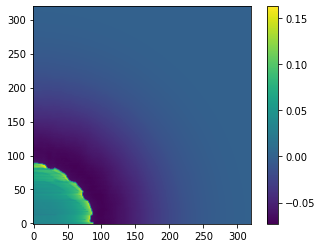

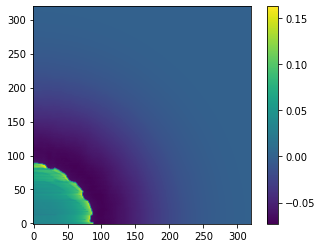

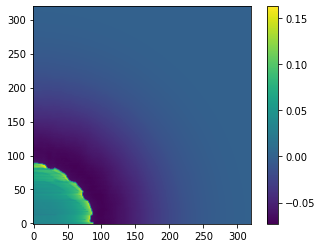

In [10]:
%run wgan_train_builder.py

In [1]:
import xarray as xr
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import os,sys
import random
from skimage.transform import resize
import models
sys.path.insert(0,'/home/huangz78/hydro/unet3d/')
import torch.fft as F
from models.unet3d_model import UNet3D, ResidualUNet3D 
from models.dnet import weights_init, Discriminator
from importlib import reload
import utils
from utils import *
import copy
import abel
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


tensor([ 0,  6, 11, 17, 23, 29, 34, 40], dtype=torch.int32)

In [ ]:
testdata_path = '/mnt/DataB/data_xfer/perturbed_densities_2D_RMI-002.npy'
data = np.load(testdata_path)

In [ ]:
print(data.shape) # scatter_level*case_num*time_pt
heg = data.shape[3]
wid = data.shape[4]
print(f'heg={heg},wid={wid}')
# find non-trivial data
usefullist = []
for case_num in range(5):
    for time_pt in range(8):
        if np.sum(np.abs(data[0,case_num,time_pt,:,:]))!= 0:
#             print(case_num,time_pt)
            usefullist.append([case_num,time_pt])

## data extraction

In [ ]:
scatter_level = 4
scatter_data  = np.zeros((len(usefullist),640,640))
scatter_data_orig = np.zeros((len(usefullist),heg,wid))
for ind in range(len(usefullist)):
    case_num = usefullist[ind][0]
    time_pt  = usefullist[ind][1]
    img_gt = data[0,case_num,time_pt,:,:]
    img_ns = data[4,case_num,time_pt,:,:]
    noise  = img_ns - img_gt
    scatter_data_orig[ind,:,:] = noise
    scatter_data[ind,:,:] = resize(noise,(640,640),anti_aliasing=True,order=5)

In [ ]:
# np.savez('/mnt/DataB/hydro_simulations/noise_source.npz',data_fullsize=scatter_data_orig,data=scatter_data)

In [ ]:
for ind in range(len(scatter_data)):
    print(f'max val of case {ind:2d}, downsampled: {np.abs(scatter_data[ind,:,:]).max()}')
    print(f'max val of case {ind:2d}, original.  : {np.abs(scatter_data_orig[ind,:,:]).max()}')
# for ind in range(len(scatter_data)):
#     plt.figure()
# #     plt.plot(scatter_data[ind,320,:])
#     plt.plot(scatter_data[ind,:,320])
# #     plt.plot(scatter_data_orig[ind,heg//2,:])
# #     plt.plot(scatter_data_orig[ind,:,wid//2])
#     plt.title(f'case {ind}')
#     plt.show()

In [ ]:
plt.figure()
plt.imshow(scatter_data[0,:,:],origin='lower')
plt.colorbar()
plt.show()

In [ ]:
plt.figure()
plt.imshow(scatter_data_orig[0,:,:],origin='lower')
plt.colorbar()
plt.show()

## data view and comparison

In [ ]:
for ind in range(len(usefullist)):
    case_num = usefullist[ind][0]
    time_pt  = usefullist[ind][1]
    img_gt = data[0,case_num,time_pt,:,:]
    plt.figure()
    plt.imshow(img_gt,vmin=0,vmax=30)
#     plt.imshow(img_gt/np.max(np.abs(img_gt)),vmin=0,vmax=1)
    plt.title(f'gt. case {case_num}, time {time_pt}')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.show()

In [ ]:
ind = 20
case_num = usefullist[ind][0]
time_pt  = usefullist[ind][1]
img_gt = data[0,case_num,time_pt,:,:]
img_ns = data[4,case_num,time_pt,:,:]
noise  = img_ns - img_gt

fig, axs = plt.subplots(1, 3,figsize=(18,18))
hd1 = axs[0].imshow(img_gt, vmin=0, vmax=35)
axs[0].set_title('gt')
fig.colorbar(hd1, ax=axs[0],fraction=0.046, pad=0.04)

hd2 = axs[1].imshow(img_ns, vmin=0, vmax=35)
axs[1].set_title('noisy')
fig.colorbar(hd2, ax=axs[1],fraction=0.046, pad=0.04)

hd3 = axs[2].imshow(noise)
axs[2].set_title('noise')
fig.colorbar(hd3, ax=axs[2],fraction=0.046, pad=0.04)
plt.show()

# anti_aliasing = True
# img_gt_rs = resize(img_gt,(640,640),anti_aliasing=anti_aliasing)
# img_ns_rs = resize(img_ns,(640,640),anti_aliasing=anti_aliasing)
# noise_rs  = resize(noise, (640,640),anti_aliasing=anti_aliasing)

# fig, axs = plt.subplots(1, 3,figsize=(18,18))
# hd1 = axs[0].imshow(img_gt_rs, vmin=0, vmax=35)
# axs[0].set_title('gt')
# fig.colorbar(hd1, ax=axs[0],fraction=0.046, pad=0.04)

# hd2 = axs[1].imshow(img_ns_rs, vmin=0, vmax=35)
# axs[1].set_title('noisy')
# fig.colorbar(hd2, ax=axs[1],fraction=0.046, pad=0.04)

# hd3 = axs[2].imshow(noise_rs)
# axs[2].set_title('noise')
# fig.colorbar(hd3, ax=axs[2],fraction=0.046, pad=0.04)
# plt.show()

method = 'hansenlaw'
img_gt_abel = abel.Transform(img_gt, method=method, direction='forward').transform
img_ns_abel = abel.Transform(img_ns, method=method, direction='forward').transform
noise_abel  = abel.Transform(noise,  method=method, direction='forward').transform

# line_num = 320
# plt.figure(figsize=(7,7))
# plt.plot(img_ns_abel[line_num,:] - img_gt_abel[line_num,:])
# plt.plot(np.zeros((img_gt_abel.shape[0])),'r--')
# plt.title('horizontal line profile difference in abel domain')
# plt.show()

# plt.figure(figsize=(7,7))
# plt.plot(img_ns_abel[:,line_num] - img_gt_abel[:,line_num])
# plt.plot(np.zeros((img_gt_abel.shape[0])),'r--')
# plt.title('vertical line profile difference in abel domain')
# plt.show()

# plt.figure(figsize=(7,7))
# plt.imshow(img_ns_abel - img_gt_abel)
# plt.title('noise in abel domain')
# plt.colorbar()
# plt.show()
line_num = noise.shape[0]//2
plt.figure(figsize=(7,7))
plt.plot(noise[:,line_num])
plt.plot(np.zeros((noise.shape[0])),'r--')
plt.title('horizontal line profile, original noise, in image domain')
plt.show()

plt.figure(figsize=(7,7))
plt.plot(noise[:,line_num])
plt.plot(np.zeros((noise.shape[0])),'r--')
plt.title('vertical line profile, original noise, in image domain')
plt.show()

plt.figure(figsize=(7,7))
plt.plot(noise_abel[:,line_num])
plt.plot(np.zeros((noise_abel.shape[0])),'r--')
plt.title('horizontal line profile, original noise, in Abel domain')
plt.show()

plt.figure(figsize=(7,7))
plt.plot(noise_abel[:,line_num])
plt.plot(np.zeros((noise_abel.shape[0])),'r--')
plt.title('vertical line profile, original noise, in Abel domain')
plt.show()

# line_num = 320
# plt.figure(figsize=(7,7))
# plt.plot(noise_rs[:,line_num])
# plt.plot(np.zeros((noise_rs.shape[0])),'r--')
# plt.title('horizontal line profile, directly resized noise, in image domain')
# plt.show()

# plt.figure(figsize=(7,7))
# plt.plot(noise_rs[:,line_num])
# plt.plot(np.zeros((noise_rs.shape[0])),'r--')
# plt.title('vertical line profile, directly resized noise, in image domain')
# plt.show()

In [ ]:
line_num = noise.shape[0]//2
plt.figure(figsize=(7,7))
plt.plot(img_gt_abel[:,line_num])
plt.plot(np.zeros((img_gt_abel.shape[0])),'r--')
plt.title('horizontal line profile, original image, in abel domain')
plt.show()

plt.figure(figsize=(7,7))
plt.plot(img_gt_abel[:,line_num])
plt.plot(np.zeros((img_gt_abel.shape[0])),'r--')
plt.title('vertical line profile, original image, in abel domain')
plt.show()

## data view

In [ ]:
scatter_level = 4
case_num      = 0
time_pt       = 0
figsize       = (8,8)

plt.figure(figsize=figsize)
plt.title(f'clean den, case {case_num}, time {time_pt}')
plt.imshow(data[0,case_num,time_pt,:,:],origin='lower')
plt.colorbar()
plt.show()

plt.figure(figsize=figsize)
plt.title(f'noisy - clean, scatter {scatter_level}, case {case_num}, time {time_pt}')
plt.imshow(np.log10(np.abs(data[scatter_level,case_num,time_pt,:,:]-data[0,case_num,time_pt,:,:])),origin='lower')
plt.colorbar()
plt.show()

In [ ]:
from IPython.display import clear_output
dep = 8
subgroup = 0
plt.figure()
for i in range(dep):
    plt.imshow(data[0,0,i,:,:],origin='lower')
    plt.colorbar()
    plt.clim(np.min(data[0,0,:,:,:]), np.max(data[0,0,:,:,:]))
#     plt.title('Frame %d' % (i+1))
    plt.title('Frame %d' % (i+1+dep*subgroup))
#     plt.savefig(f'/home/huangz78/checkpoints/frame_{i}.jpg',bbox_inches='tight', transparent=True,
#                pad_inches=.2, dpi=300)
    plt.show()
    clear_output(wait=True)

## with hydro data

In [ ]:
datapath = '/mnt/DataB/hydro_simulations/data/'

ncfiles = list([])
for file in os.listdir(datapath):
    if file.endswith(".nc"):
        ncfiles.append(file)
print('Total amount of files:', len(ncfiles))
img_size = 320
dep = 8

batchsize = 2
fileexp_inds = [7736+i for i in range(batchsize)]

dyn   = torch.zeros((batchsize,1,dep,img_size,img_size)) # load one sample, show it
noise = torch.zeros((batchsize,1,dep,img_size,img_size)) # make a noise sample, add it to ground truth, show it

normalization = 50

for fileexp_ind in range(len(fileexp_inds)):
    filename = ncfiles[fileexp_inds[fileexp_ind]]
    sim = xr.open_dataarray(datapath+filename)
    # val.append(np.max(np.array(sim)[:dep,:,:].flatten()))
    sim.close()
    for t in range(dep):
        dyn[fileexp_ind,0,t,:,:] = \
        torch.tensor( sim.isel(t=t)[:img_size,:img_size].values ).clamp(max=normalization)/normalization

In [ ]:
plt.figure()
img = dyn[0,0,0,:,:]
plt.imshow(img,origin='lower',vmin=-.2,vmax=0.6)
plt.colorbar()
plt.show()

In [ ]:
reload(utils)
from utils import *

In [ ]:
noises = noise_generate(dyn,mode='real')

In [ ]:
plt.figure()
img = noises[0,0,0,:,:]
plt.imshow(img,origin='lower',vmin=-.2,vmax=0.6)
plt.colorbar()
plt.show()

In [ ]:
img = dyn[0,0,0,:,:]
img_full = complete(img)

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(img_full)
plt.colorbar()
plt.show()

In [ ]:
method = 'hansenlaw'
img_abel  = abel.Transform(img_full, method=method, direction='forward').transform
img_recon = abel.Transform(img_abel, method=method, direction='inverse').transform

c = np.abs(img_abel).mean()
factor = np.random.uniform(low=0 , high=.0005*c)
bias   = np.random.uniform(low=-.0005*c , high=.0005*c)
print(f'factor = {factor}, bias = {bias}')
print(img_abel.shape)
print(type(img_abel))

x, y = meshgrid(...)
# noise          = factor * img_abel + bias
img_abel_noisy = img_abel + noise
# img_recon_noisy = abel.direct.direct_transform(img_abel_noisy,direction='forward')
img_recon_noisy = abel.Transform(img_abel_noisy, method=method, direction='inverse').transform


err_recon_gt = np.linalg.norm(img_recon-img_full,ord='fro')/np.linalg.norm(img_full,ord='fro')
print(f'method: {method},  diff btw recon and gt: {err_recon_gt}')

plt.figure(figsize=(10,10))
plt.title('central line profile ---  image domain')
plt.plot(img_full[320,:],color='r',label='clean')
# plt.plot(img_recon[320,:],color='g',label='abel recon, no noise')
plt.plot(img_recon_noisy[320,:],color='g',linestyle='-.',label='abel recon, linear rand. noise')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(10,10))
plt.title('central line profile --- error')
plt.plot(img_recon_noisy[320,:] - img_full[320,:],color='b')
plt.legend(loc='best')
plt.show()

In [ ]:
# plt.figure(figsize=(10,10))
# plt.imshow(img_abel)
# plt.colorbar()
# plt.show()

plt.figure(figsize=(10,10))
plt.title('central line profile_abel ground truth')
plt.plot(img_abel[320,:],label='clean')
plt.plot(img_abel_noisy[320,:],label='noisy')
plt.legend(loc='best')
plt.show()